#Load a pre-trained model

In [23]:
from keras.applications.vgg16 import VGG16
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Visualize Filters

In [24]:
for layer in model.layers: # access all the layers
  print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


In [25]:
for layer in model.layers:
  if 'conv' in layer.name:
    filters, biases =layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


(3, 3, 3, 64) ->
(height, width, channels, number_of_filters)

In [26]:
filters, biases= model.layers[1].get_weights() # weights from the 2nd hidden layer
filters.shape 

(3, 3, 3, 64)

In [27]:
filters[:, :, :, 0].shape #1st filter

(3, 3, 3)

 * Normalize values between 0 and 1

 x$_{i_{normalized}}$ = (x$_i$ – x$_{min}$) / (x$_{max}$ – x$_{min}$)

In [28]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

 Plot filters 

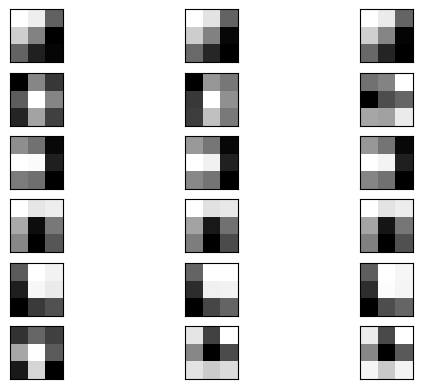

In [29]:
import matplotlib.pyplot as plt

n_filters, ix = 6, 1
for i in range(n_filters):
	f = filters[:, :, :, i]
	for j in range(3): #3 channels
		plt.subplot(n_filters, 3, ix)
		plt.xticks([])
		plt.yticks([])
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
plt.show()

Dark squares indicate small weights and the light squares represent large weights

# Visualize Feature Maps

* Each value in the feature map represents the activation of a feature/filter at a specific location in the input image
* Feature maps close to the input detect small or fine-grained detail
* Feature maps close to the output detect more general features.

In [30]:
#input for the VGG16 model
import requests

url = "https://machinelearningmastery.com/wp-content/uploads/2019/02/bird.jpg"
response = requests.get(url)

with open("bird.jpg", "wb") as f:
    f.write(response.content)

In [31]:
#output of each convolutional layers
for i, layer in enumerate(model.layers):
  if 'conv' not in layer.name:
    continue
  print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


* Create a new model with the same input layer as the original model, but the output would be the output of a convolutional layer
* Making a prediction with this model will give the feature map for the first convolutional layer for a given input image

In [32]:
from keras.models import Model

feature_map_model = Model(inputs= model.inputs, outputs=model.layers[1].output)

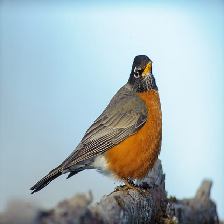

In [33]:
from keras.applications.vgg16 import preprocess_input
from keras.utils import load_img, img_to_array
from numpy import expand_dims

img = load_img('bird.jpg', target_size=(224, 224))
img

In [34]:
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)

In [35]:
feature_maps = feature_map_model.predict(img)

1/1 [==============================] - 0s 74ms/step


In [36]:
feature_maps.shape

(1, 224, 224, 64)

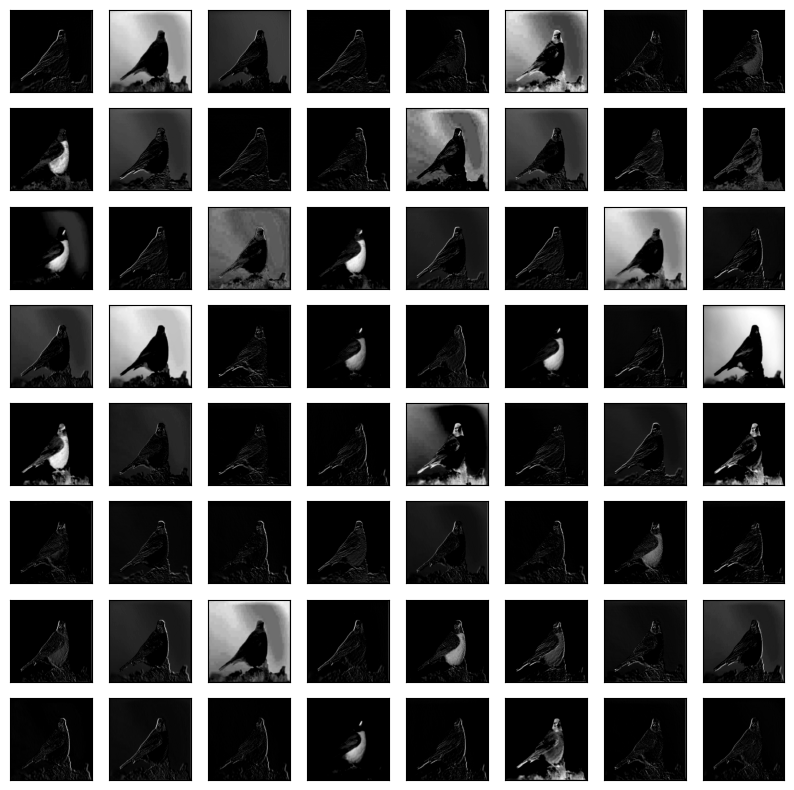

In [37]:
plt.figure(figsize=(10,10))
i = 0
for _ in range(8):
  for _ in range(8):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0, :, :, i], cmap="gray")
    i+=1
plt.show()

### 2nd approach
* We can define a new model that has multiple outputs, one feature map output for each last convolutional layer in each block

In [52]:
outputs = [layer.output for layer in model.layers if "pool" in layer.name]
feature_map_model = Model(inputs=model.inputs, outputs=outputs)
feature_maps = feature_map_model.predict(img)

1/1 [==============================] - 1s 703ms/step


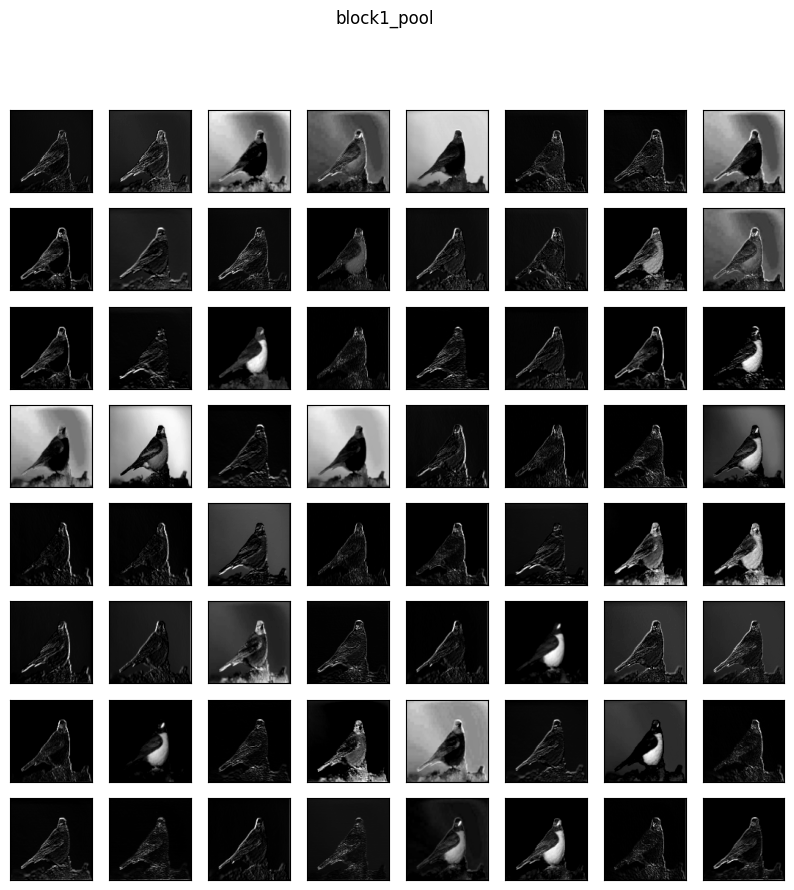

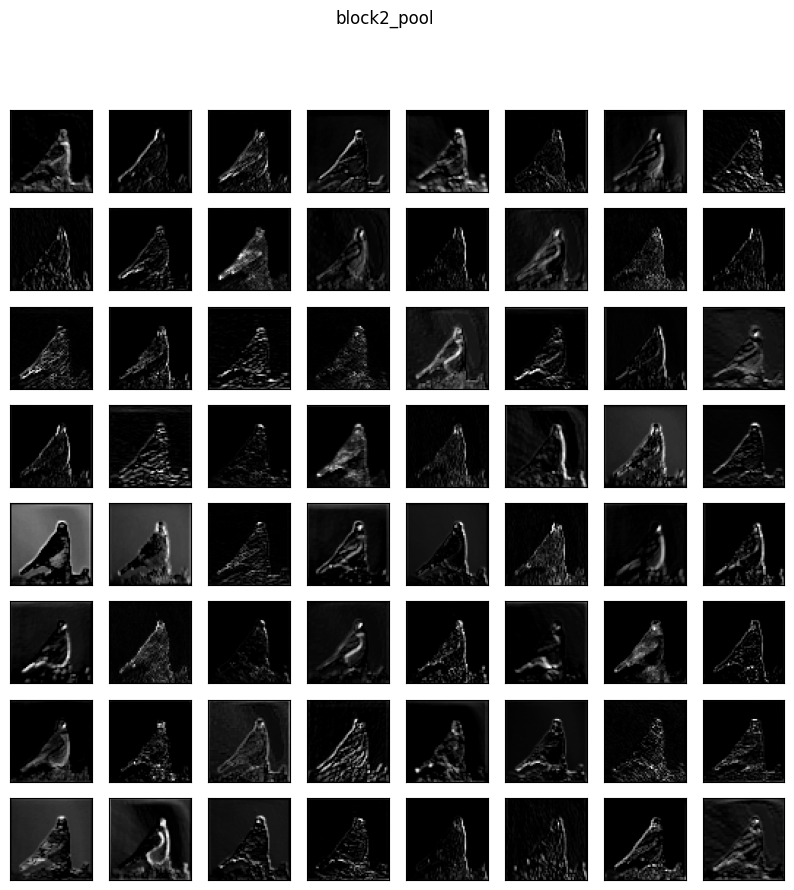

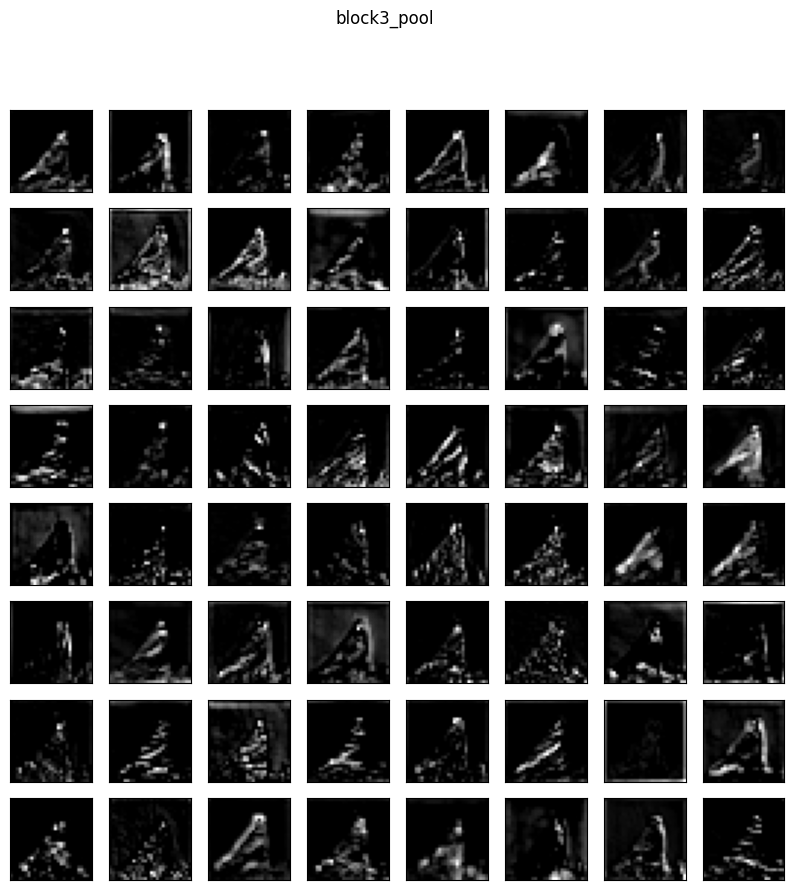

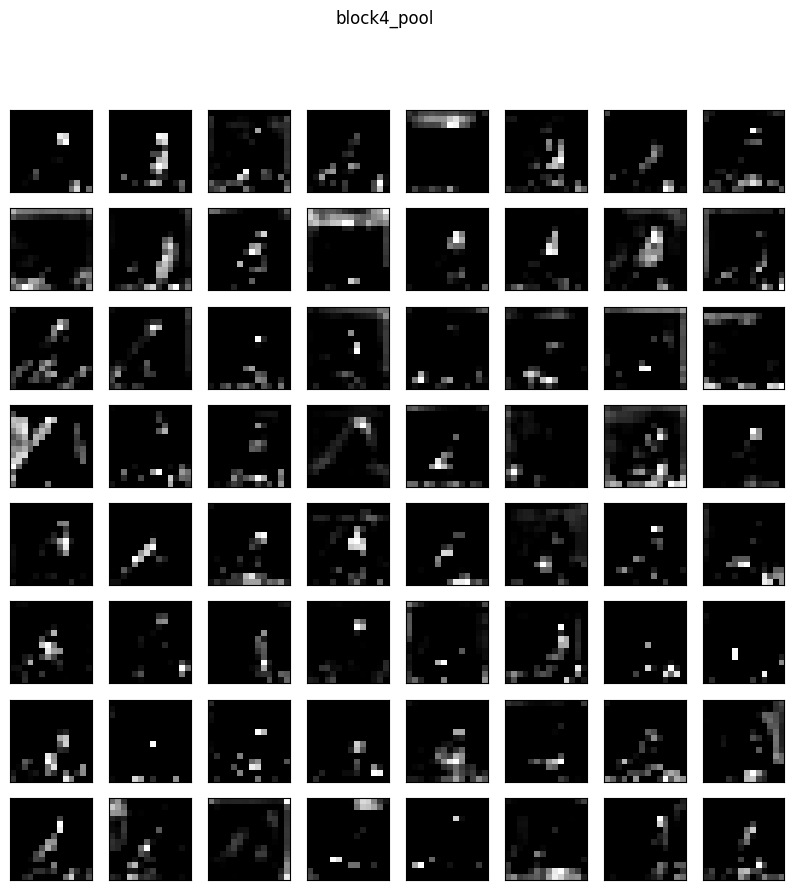

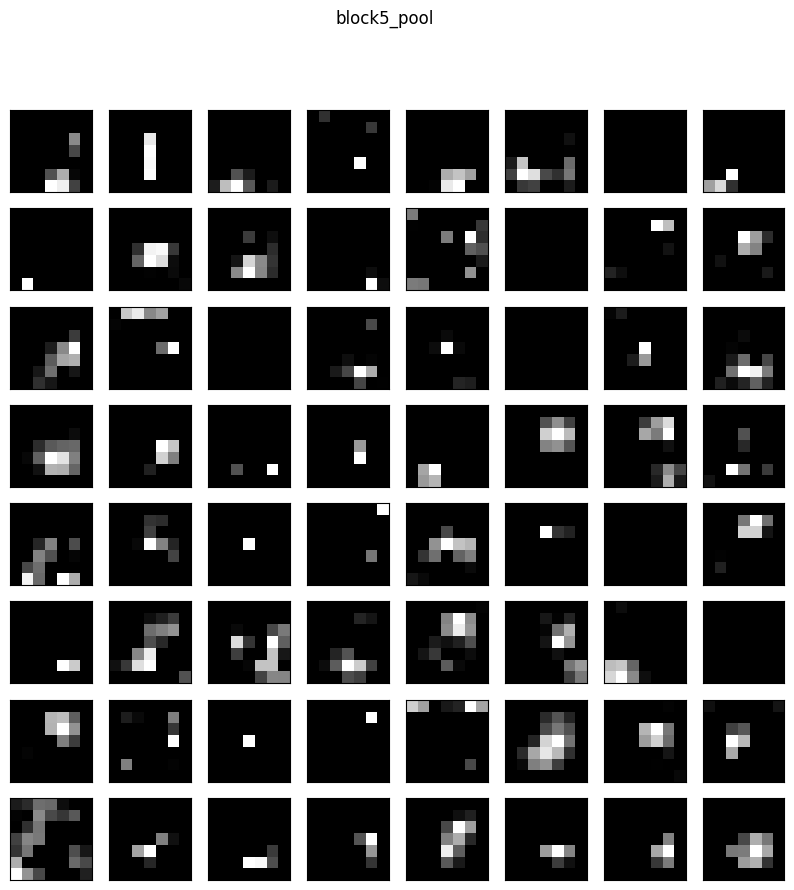

In [69]:
for output, fmap in zip(outputs, feature_maps):   
  ix = 0
  plt.figure(figsize=(10,10))
  plt.suptitle(output.name.split("/")[0])  
  for _ in range(8):
    for _ in range(8):
      plt.subplot(8, 8, ix+1)
      plt.xticks([])
      plt.yticks([])      
      plt.imshow(fmap[0, :, :, ix], cmap='gray')
      ix+=1
  plt.show()

* As we go deeper into the model, it abstracts the features from the image into more general concepts that can be used to make a classification
* We generally lose the ability to interpret the deeper feature maps